In [62]:
from matplotlib import pyplot as plt 
import numpy as np
fft_shift = np.fft.fftshift
fft = np.fft.fft2

In [104]:
import cv2
def get_signature_from_image(filename):
    image = cv2.imread(filename)
    result = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array([90, 38, 0])
    upper = np.array([145, 255, 255])
    mask = cv2.inRange(image, lower, upper)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)

    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    boxes = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        boxes.append([x,y, x+w,y+h])

    boxes = np.asarray(boxes)
    left = np.min(boxes[:,0])
    top = np.min(boxes[:,1])
    right = np.max(boxes[:,2])
    bottom = np.max(boxes[:,3])

    result[close==0] = (255,255,255)
    ROI = result[top:bottom, left:right].copy()
    cv2.rectangle(result, (left,top), (right,bottom), (36, 255, 12), 2)
    return ROI

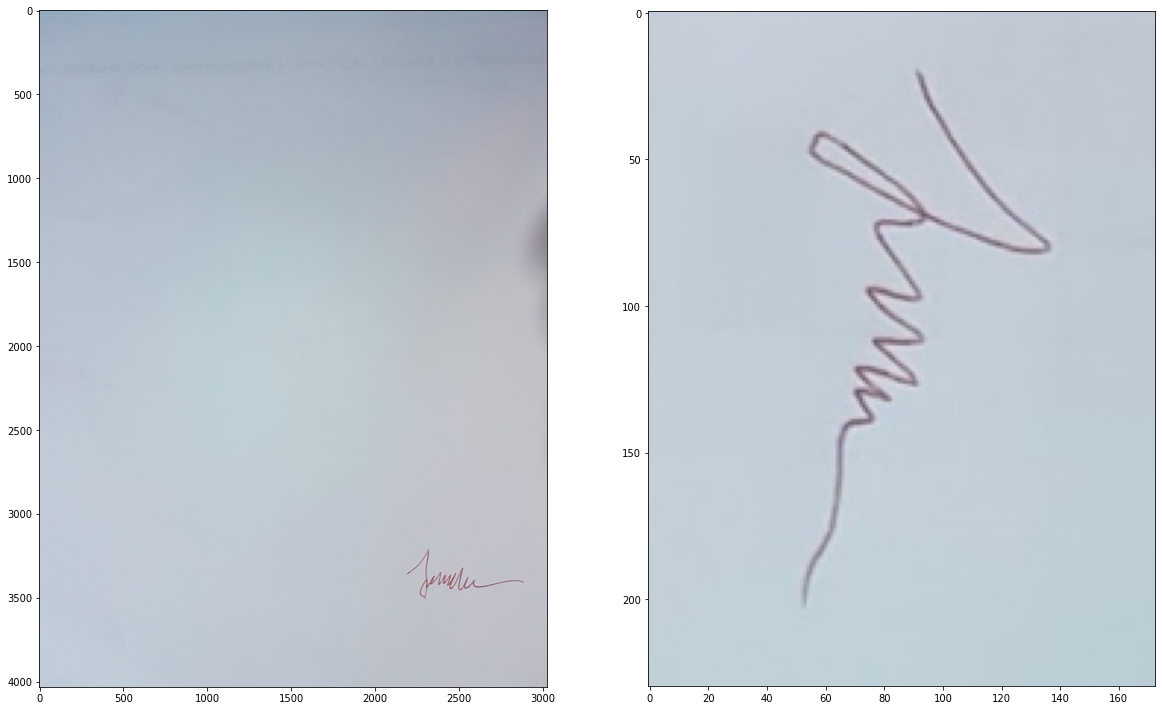

In [119]:
import cv2 as cv
signature = cv.imread('im2.jpg')
image = cv.imread('imza-1.jpg')
plt.figure(figsize=(20,20))
plt.subplot(1,2,1), plt.imshow(image)
plt.subplot(1,2,2), plt.imshow(signature)
signature = cv.cvtColor(signature, cv.COLOR_BGR2GRAY)

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1ac82fa5d30>)

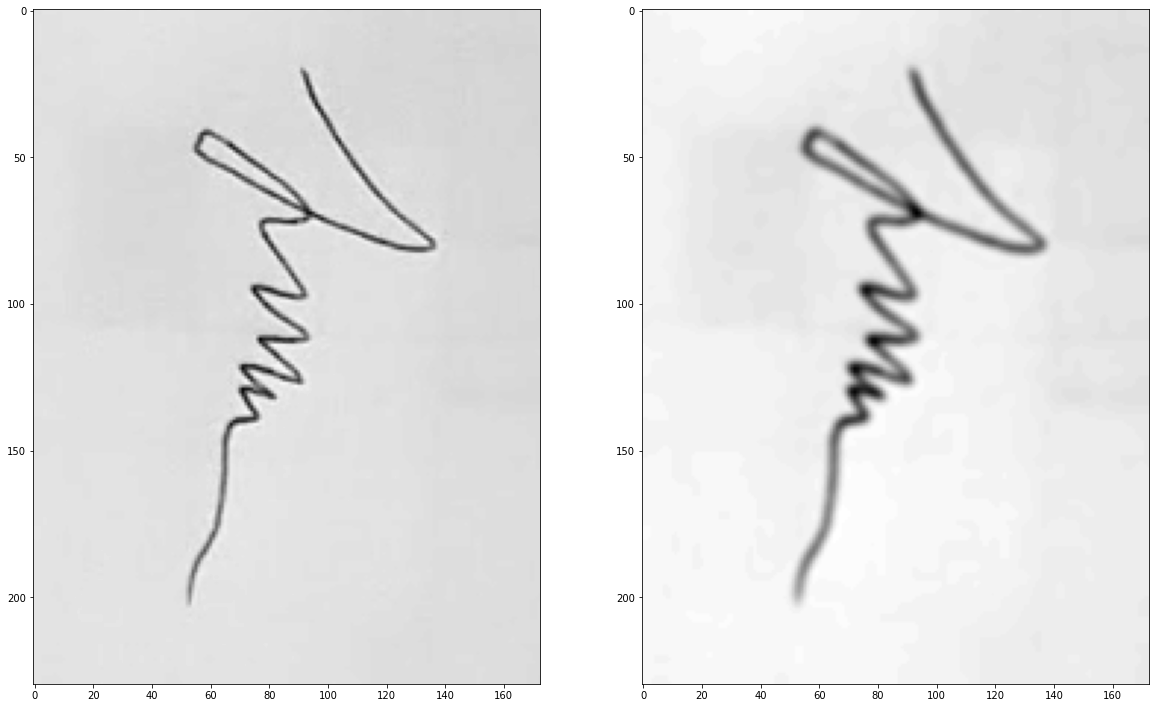

In [120]:
blurred = cv.GaussianBlur(signature, (7,7), 0)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1), plt.imshow(signature, cmap ='gray')
plt.subplot(1,2,2), plt.imshow(blurred, cmap ='gray')

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1ac8334b220>)

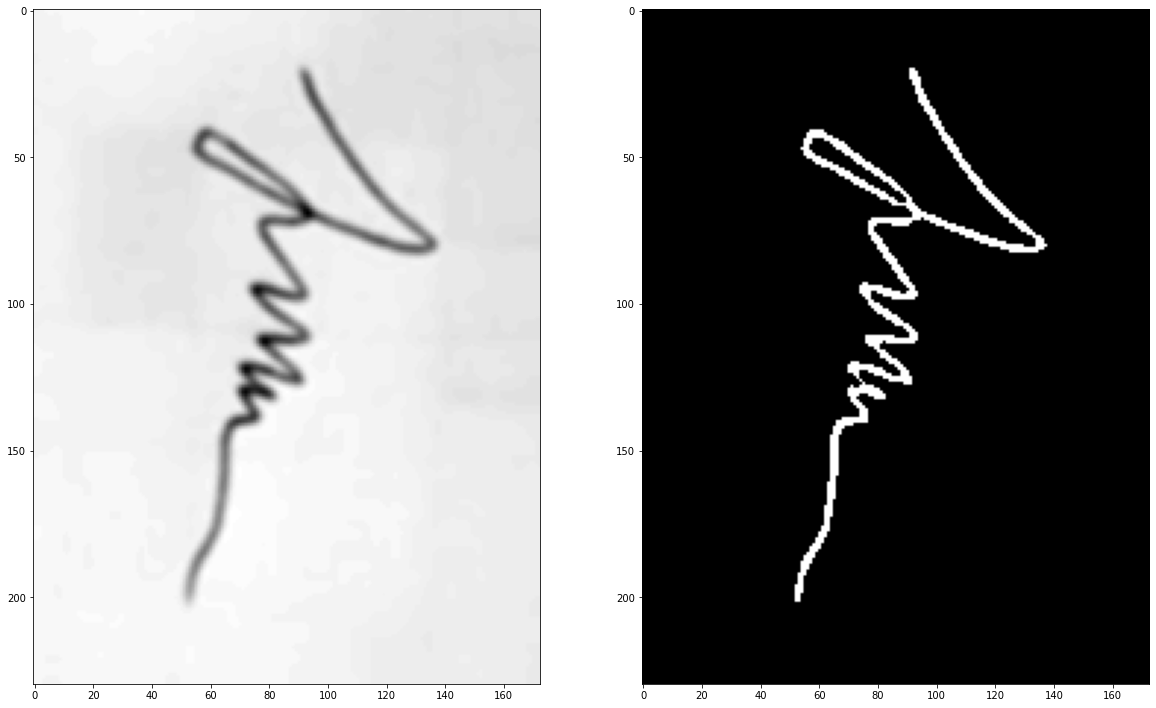

In [121]:
binary_sign = cv.adaptiveThreshold(blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 5,2)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1), plt.imshow(blurred, cmap = 'gray')
plt.subplot(1,2,2), plt.imshow(binary_sign, cmap = 'gray')

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1ac833f27c0>)

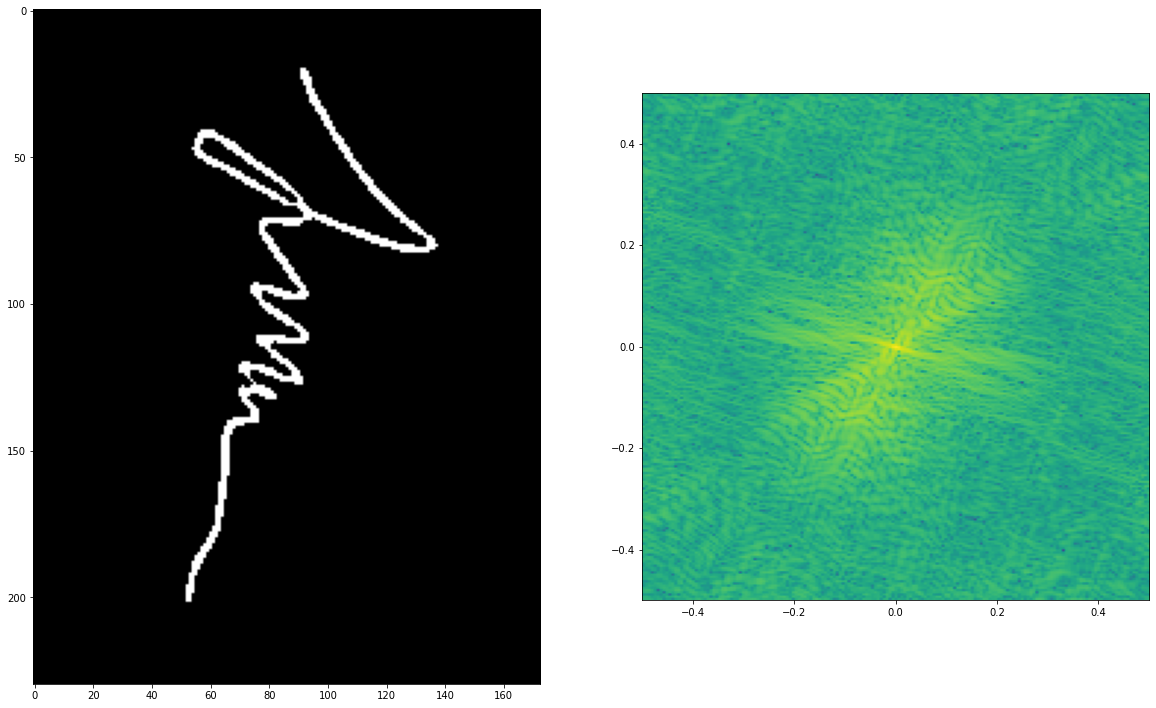

In [122]:
F_I = fft_shift(np.abs(fft(binary_sign)))
plt.figure(figsize=(20,20))
plt.subplot(1,2,1), plt.imshow(binary_sign, cmap = 'gray')
plt.subplot(1,2,2), plt.imshow(np.log(F_I + 1), extent = [-0.5, 0.5, -0.5, 0.5])

In [123]:
print(F_I.shape)

(230, 173)


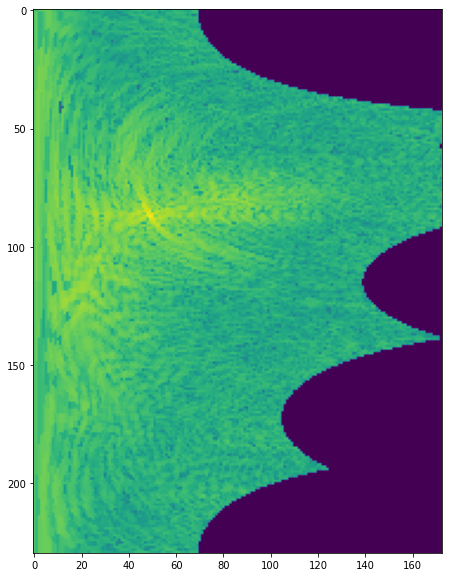

In [130]:
value = np.sqrt(((F_I.shape[0] / 2.0) ** 2.0) + ((F_I.shape[1] / 2.0) ** 2.0))
polar_image = cv2.linearPolar(F_I,(F_I.shape[0]/2, F_I.shape[1]/2), value, cv2.WARP_FILL_OUTLIERS)
plt.figure(figsize=(10 , 10))
plt.imshow(np.log(polar_image + 1))

In [125]:
print(polar_image.shape)

(230, 173)


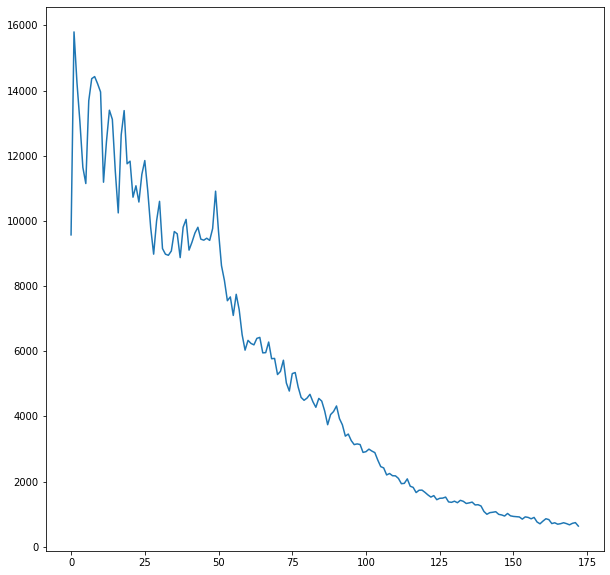

In [131]:
mean = np.zeros(polar_image.shape[1])
for i in range(polar_image.shape[1]):
    mean[i] = np.mean(polar_image[:, i])
    
plt.figure(figsize=(10, 10))
plt.plot(mean)


In [127]:
peak = mean.argmax()
print(peak)

1


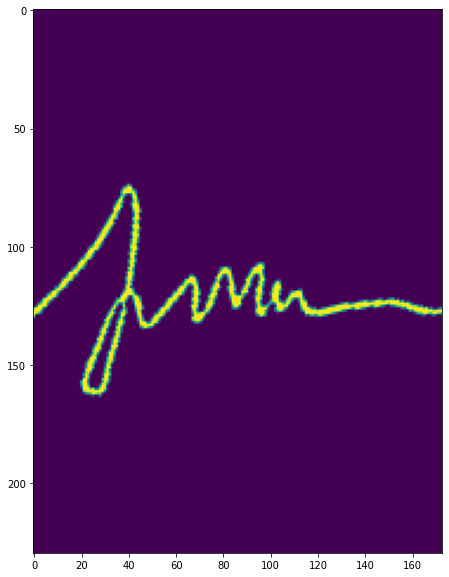

In [132]:
h, w = binary_sign.shape[:2]
cX, cY = w // 2, h // 2
rotationRate = 15

M = cv.getRotationMatrix2D((cX, cY), -peak % (90 + rotationRate), 1.0)
rotated = cv.warpAffine(binary_sign, M, (w, h))

plt.figure(figsize=(10, 10))
plt.imshow(rotated)